In [1]:
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from copy import deepcopy
import random

In [2]:
## Classes

hitID = 0 # global hit counter

# detector range
xrange = [-2, 50]
yrange = [-14,14]


class track2D :
    def __init__(self,a,b, kind="ab") :
        if not kind in ["ab","zt"] : 
            raise Exception("Error: {0} is not a valid track type".format(kind))
        self.hitlist = []
        self.kind = kind
        self.a = a
        self.b = b
        
    def y(self,z) :
        if(self.kind=="ab") :
            # y = ax+b
            return self.a * z + self.b
        if(self.kind=="zt") :
            # y = (z-z0) * tan(t)
            return (z-self.a) * math.tan(self.b)

    def hits(self) :
        return self.hitlist
        
    def addHit(self, hit) :
        self.hitlist += [hit]
        
    def makeHits(self, measplanes, hiterror=0) :
        self.hitlist = []
        for z in measplanes :
            hit = hit2D(self, z, random.gauss(self.y(z), hiterror))
            self.addHit(hit)
        return self.hitlist
        
        
class hit2D :
    def __init__(self, track, z, y) :
        self.origintrack = track
        self.z = z
        self.y = y
        global hitID
        self.hitID = hitID
        hitID += 1
        
    def zy(self) :
        return [self.z,self.y]
    
    def track(self) :
        return self.origintrack
    

In [3]:
## Methods    

def makeRandomTrack(etarange = [1.5, 5.0]) :
    z = 0
    eta = random.uniform(etarange[0], etarange[1]) * random.choice([-1,1])
    theta = 2*math.atan(math.exp(-eta))
    #print(" - Generated random track: eta = {0}, theta = {1}, z = {2}".format(eta,theta,z))
    return track2D(z, theta, "zt")

def makeRandomHit(measplanes) :
    z = random.choice(measplanes)
    y = random.uniform(yrange[0],yrange[1])
    return hit2D(None, z, y)
    
def makeHits(tracks, measplanes, hiterror=0, noiserate=0) :
    hitsgrouped = [ track.makeHits(measplanes, hiterror) for track in tracks ]
    hits = [ hit for hitsintrack in hitsgrouped for hit in hitsintrack ] # flatten
    nNoiseHits = int(len(hits) * noiserate)
    for i in range(nNoiseHits) :
        noisehit = makeRandomHit(measplanes)
        hits += [noisehit]
    return hits

def htHit(hit, originz=0) :
    return math.atan( (hit.y - 0.) / (hit.z - originz) )
        
def htHistogram(hits, thetarange=[-0.40, 0.40], nbins=100) :
    hthits = list(map( htHit, hits ))
    counts, binedges = np.histogram(hthits, range=(thetarange[0], thetarange[1]), bins=nbins)
    return [counts, binedges]

def findHtMaxIndex(counts) :
    val = np.max(counts)
    index = counts.tolist().index(val)
    return val, index

def findMaxHist1D(counts, binedges, maxtracks=300, threshold=2, removespread=1) :
    angles = []
    halfbinwidth = (binedges[1]-binedges[0])/2.
    while maxtracks > 0 :
        val, index = findHtMaxIndex(counts)
        if(val < threshold) : break
        angles += [binedges[index]+halfbinwidth]
        for i in range(-removespread, removespread+1) :
            counts[index + i] = 0 # remove peak to continue search
        maxtracks -= 1
    return angles
        
def findHitsFromAngle(angle, hits, originz=0, tolerance=0.1) :
    projectTrack = track2D(originz, angle, "zt")
    hitperz = {} # allow only one hit per layer
    for hit in hits :
        # could make fancier distance measure, now just take diff in y at z
        dist = abs( hit.y - projectTrack.y(hit.z) )
        if( dist < tolerance ) :
            #projectTrack.addHit(hit)
            if not hit.z in hitperz.keys() :
                hitperz[hit.z] = [hit, dist]
            else :
                if(hitperz[hit.z][1] > dist) :
                    hitperz[hit.z] = [hit, dist]
                   
    for key, value in hitperz.items():
        projectTrack.addHit(value[0])
                   
    return projectTrack

def findTracks(angles, hits, originz=0, tolerance=0.1, minHitsOnTrack=2, verbose=1) :
    tracks = []
    hitscopy = deepcopy(hits)
    print("Finding hits for {0} cases".format(len(angles)))
    for angle in angles :
        if(verbose>1) : print("Searching hits for angle: {0:.3f} (Hits remaining: {1})".format(angle,len(hitscopy)))
        track = findHitsFromAngle(angle, hitscopy, originz, tolerance)
        if(verbose>1) : print(" --> found {0} hits within tolerance".format(len(track.hits())))
        if(len(track.hits()) >= minHitsOnTrack) :
            tracks += [track]
            # remove hits from container
            for hit in track.hits() : hitscopy.remove(hit)
        else : 
            if(verbose>1) : print(" --> not enough hits on track, removing track and keeping hits.")
        
    return tracks, hitscopy

def makeMatchTable(recotracks, tracks, minHits=2, verbose=1) :
    matchTable = [[-1, [], [], []]]*len(recotracks)
    for recotrack in recotracks :
        recoindex = recotracks.index(recotrack)
        recohitIDs = [hit.hitID for hit in recotrack.hits()]
        for track in tracks :
            hitIDs = [hit.hitID for hit in track.hits()]
            commonhits = [hitID for hitID in recohitIDs if hitID in hitIDs]
            unpurehits = [hitID for hitID in recohitIDs if not hitID in hitIDs]
            missedhits = [hitID for hitID in hitIDs if not hitID in recohitIDs]
            if len(commonhits) >= minHits :
                if((matchTable[recoindex][0] == -1) or 
                   (matchTable[recoindex][0] != -1 and len(matchTable[recoindex][1]) < len(commonhits)) ) :
                        matchTable[recoindex] = [tracks.index(track), commonhits, unpurehits, missedhits]
                        if(verbose>1) : print(" - Matched recotrack {0} with track {1} (shared hitIDs: {2}, unpure: {3}, missed: {4})".format(
                            recotracks.index(recotrack), tracks.index(track), commonhits, unpurehits, missedhits ))
    return matchTable

def getPerformance(recotracks, tracks, hits, unusedhits, minMatchHits=2, verbose=1) :
    matchTable = makeMatchTable(recotracks, tracks, minMatchHits, verbose=verbose)
    
    fakehits = sum( 1 for hit in hits if hit.track() == None )
    if(verbose) : print("Fake hits in sample:\t{0} \t/ \t{1} \t{2:.2f} %".format(fakehits, len(hits), float(fakehits)/float(len(hits))*100.))
    hitsused = len(hits) - len(unusedhits)
    hituseeff = float(hitsused) / float(len(hits))         
    if(verbose) : print("Hit use efficiency:\t{0} \t/ \t{1} \t{2:.2f} %".format(hitsused, len(hits), hituseeff*100.))
    ntracksmatched = sum(1 for match in matchTable if match[0] != -1)
    trackeff = float(ntracksmatched) / float(len(tracks))
    if(verbose) : print("Track efficiency:\t{0} \t/ \t{1} \t{2:.2f} %".format(ntracksmatched, len(tracks), trackeff*100.))
    ghosttracks = len(recotracks) - ntracksmatched
    ghostrate = float(ghosttracks) / float(len(recotracks))
    if(verbose) : print("Ghost rate:\t\t{0} \t/ \t{1} \t{2:.2f} %".format(len(recotracks) - ntracksmatched, len(recotracks), ghostrate*100.))
    commonhits = sum( len(match[1]) for match in matchTable )
    unpurehits = sum( len(match[2]) for match in matchTable )
    missedhits = sum( len(match[3]) for match in matchTable )
    totaltrackhits = commonhits + missedhits
    totalrecotrackhits = commonhits + unpurehits
    if(verbose) : print("Track hit efficiency:\t{0} \t/ \t{1} \t{2:.2f} %".format(commonhits, totaltrackhits, float(commonhits / totaltrackhits)*100. ))
    if(verbose) : print("Track hit purity:    \t{0} \t/ \t{1} \t{2:.2f} %".format(commonhits, totalrecotrackhits, float(commonhits / totalrecotrackhits)*100. ))
    


In [4]:
## Visualisation

def drawDet(measplanes, xrange=xrange, yrange=yrange) :
    plt.figure(figsize=(12,6))
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.plot(0, 0, marker="o", color="black")
    plt.xlabel("z")
    plt.ylabel("y")
    for z in measplanes :
        plt.gca().add_patch(mpl.patches.Rectangle((z-0.2,yrange[0]+1),0.4,yrange[1]-yrange[0]-2, color="lightgrey"))

def drawTracks(tracks, xrange=xrange, yrange=yrange, style="-", plotHitCountThreshold=2) :
    tran = [0, xrange[1]-1]
    for track in tracks :
        if( len(track.hits()) >= plotHitCountThreshold ) :
            plt.plot( tran, [track.y(tran[0]), track.y(tran[1])], color="black", linestyle=style)
        
def drawHits(hits) :
    hits_zy = [ hit.zy() for hit in hits ]
    plt.plot( *np.array(hits_zy).T, marker="o", linestyle="" )
    
def drawHtHist(counts, binedges) :
    plt.hist(binedges[:-1], binedges, weights=counts)
    plt.xlabel(r"$\theta$")

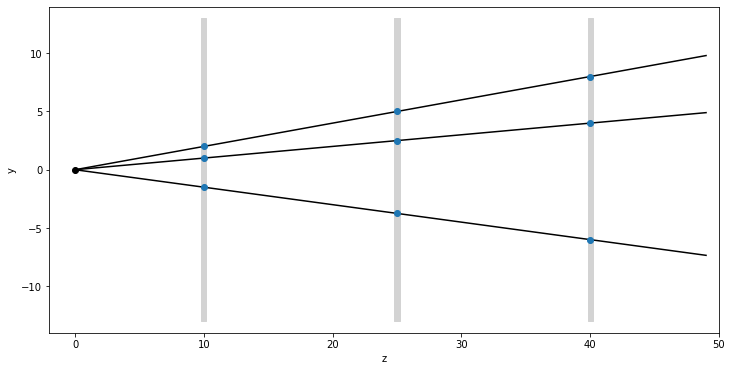

In [5]:
## Setup

# define z's of measurement planes
measplanes = [10,25,40] 

# make tracks
tracks = [ track2D(0.1, 0.0),
           track2D(0.2, 0.0),
           track2D(-0.15,0.0) ]

# generate hits
hits = makeHits(tracks, measplanes)

# draw generated
drawDet(measplanes)
drawTracks(tracks)
drawHits(hits)

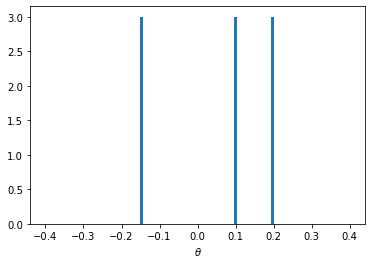

In [6]:
# do 2D Hough transform of hits

nbins = 100
hist = htHistogram(hits, nbins = nbins)

drawHtHist(*hist)

In [7]:
# find the peaks in the Hough spectrum

threshold = 2
removespread = 1
maxima = findMaxHist1D(*hist, threshold=threshold, removespread=removespread)

print(maxima)

[-0.14800000000000002, 0.09999999999999998, 0.19599999999999995]


Finding hits for 3 cases
Searching hits for angle: -0.148 (Hits remaining: 9)
 --> found 3 hits within tolerance
Searching hits for angle: 0.100 (Hits remaining: 6)
 --> found 3 hits within tolerance
Searching hits for angle: 0.196 (Hits remaining: 3)
 --> found 3 hits within tolerance


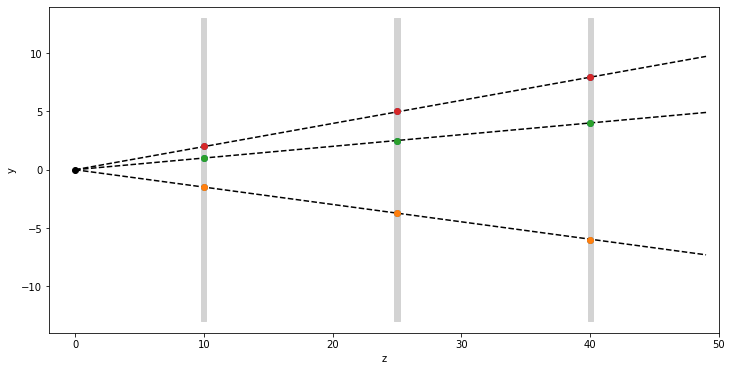

In [8]:
# find the hits belonging to those angles

originz = 0
tolerance = 0.2
recotracks, unusedhits = findTracks(maxima, hits, originz, tolerance, verbose=2)

# draw
drawDet(measplanes)
drawHits(hits)
drawTracks(recotracks, style="--")
for track in recotracks :
    drawHits(track.hits())

In [13]:
# performance statistics

getPerformance(recotracks, tracks, hits, unusedhits, verbose=2)

 - Matched recotrack 0 with track 2 (shared hitIDs: [6, 7, 8], unpure: [], missed: [])
 - Matched recotrack 1 with track 0 (shared hitIDs: [0, 1, 2], unpure: [], missed: [])
 - Matched recotrack 2 with track 1 (shared hitIDs: [3, 4, 5], unpure: [], missed: [])
Fake hits in sample:	0 	/ 	9 	0.00 %
Hit use efficiency:	9 	/ 	9 	100.00 %
Track efficiency:	3 	/ 	3 	100.00 %
Ghost rate:		0 	/ 	3 	0.00 %
Track hit efficiency:	9 	/ 	9 	100.00 %
Track hit purity:    	9 	/ 	9 	100.00 %


# And now for an event loop

- With tracks randomly generated
- hit errors and random noise hits

In [10]:
# loop object

def doEvent(nTracks=10, draw=True, verbose=1) :
    tracks = [ makeRandomTrack() for i in range(nTracks) ]
    hits = makeHits(tracks, measplanes, hiterror, noiserate)
    hist = htHistogram(hits, nbins = nbins)
    if(draw) : drawHtHist(*hist)
    maxima = findMaxHist1D(*hist, threshold=threshold, removespread=removespread)
    recotracks, unusedhits = findTracks(maxima, hits, originz, tolerance, verbose=verbose)
    
    if(draw) :
        drawDet(measplanes)
        drawHits(hits)
        drawTracks(recotracks, style="--")
        for track in recotracks :
            drawHits(track.hits())
            
    getPerformance(recotracks, tracks, hits, unusedhits, verbose=verbose)

In [11]:
# set settings for loop

# detector
measplanes = [10,25,40] 

# generation
nTracks = 10
hiterror = 0.05
noiserate = 0.2

# hough transform
nbins = 150

# peak search
threshold = 2
removespread = 0

# hit finding
originz = 0
tolerance = 0.2

Finding hits for 9 cases
Searching hits for angle: 0.024 (Hits remaining: 36)
 --> found 3 hits within tolerance
Searching hits for angle: -0.259 (Hits remaining: 33)
 --> found 3 hits within tolerance
Searching hits for angle: -0.211 (Hits remaining: 30)
 --> found 3 hits within tolerance
Searching hits for angle: -0.195 (Hits remaining: 27)
 --> found 3 hits within tolerance
Searching hits for angle: -0.168 (Hits remaining: 24)
 --> found 3 hits within tolerance
Searching hits for angle: -0.029 (Hits remaining: 21)
 --> found 3 hits within tolerance
Searching hits for angle: 0.019 (Hits remaining: 18)
 --> found 2 hits within tolerance
Searching hits for angle: 0.035 (Hits remaining: 16)
 --> found 3 hits within tolerance
Searching hits for angle: 0.205 (Hits remaining: 13)
 --> found 3 hits within tolerance
 - Matched recotrack 0 with track 9 (shared hitIDs: [324, 325, 326], unpure: [], missed: [])
 - Matched recotrack 1 with track 2 (shared hitIDs: [303, 304, 305], unpure: [], miss

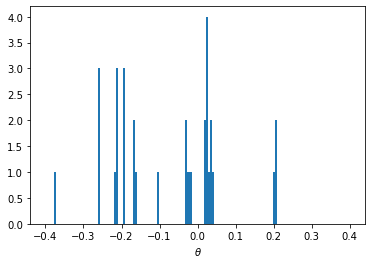

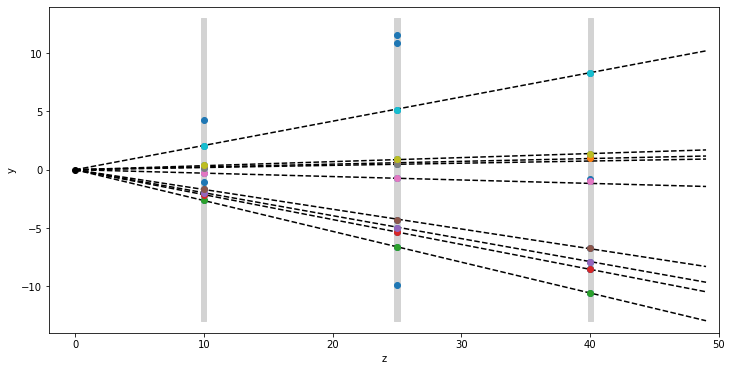

In [21]:
# do events

random.seed(4)
doEvent(nTracks, draw=True, verbose=2)